# Импорты

In [104]:
import pandas as pd
import numpy as np
from pathlib import Path

## Дефолтные настройки Matplotlib

In [105]:
import matplotlib.pyplot as plt

# устанавливаем дефолтные размеры шрифтов
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [106]:
convert_type_dict = {'parameter1': float,
                    'parameter2': float,
                    'criteria1': float,
                    'criteria2': float,
                    'constraint1': bool,
                    'constraint2': bool,
                    }

Загрузка датасета

In [107]:
def load_data(path: Path):
    print("Read data set from path {path}".format(path=path))
    df = pd.read_csv(path).astype(convert_type_dict)
    return df

Непосредственно загрузка

In [108]:
data_1_path = Path("data/DataSet900.csv")
data_2_path = Path("data/DataSet1000.csv")
data_3_path = Path("data/DataSet100000.csv")
data_4_path = Path("data/DataSet129600.csv")

data_1 = load_data(data_1_path)
data_2 = load_data(data_2_path)
data_3 = load_data(data_3_path)
data_4 = load_data(data_4_path)

dataset = data_1

Read data set from path data\DataSet900.csv
Read data set from path data\DataSet1000.csv
Read data set from path data\DataSet100000.csv
Read data set from path data\DataSet129600.csv


Шапка датасета, первые 5 записей  набора данных.

Код описывающий сохранение графиков и рисунков

In [109]:
IMAGES_PATH = Path() / "imgs"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Устанавливаем параметр рандомизации (что бы значения повторялись при запуске)

In [110]:
np.random.seed(30)

Новый критерий сильно коррелирует с нашим параметром

In [111]:
import torch
from typing import List
import pickle
from torch import nn
from torch.utils.data import DataLoader, Dataset

## Установить роботу с куда или нна цп

In [112]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Working with data

In [113]:
class MyDataset(Dataset):
    '''
    Dataset:
    '''
    def __init__(self, 
                 data:pd.DataFrame,
                 input_colums: List[str],
                 output_colums: List[str]) -> None:
        self.input_colums = input_colums
        self.output_colums = output_colums
        
        x = data[self.input_colums].values
        y = data[self.output_colums].values
        
        self.x_train = torch.tensor(x, dtype=torch.float32)
        self.y_train = torch.tensor(y, dtype=torch.float32)      
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index]    

# Creating Models

In [114]:

class NeuralNetwork(nn.Module):
    '''
    Define neural network model:
    '''
    def __init__(self, inputs, outputs, middle_layers=128):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(            
            nn.Linear(inputs, middle_layers),
            nn.ReLU(),
            nn.Linear(middle_layers, middle_layers),
            nn.ReLU(),
            nn.Linear(middle_layers, middle_layers),
            nn.ReLU(),
            nn.Linear(middle_layers, outputs)
        )

    def forward(self, x: torch.Tensor):
        logits = self.linear_relu_stack(x)
        return logits

test = NeuralNetwork(2,2).to(device)
print(test)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)


# Optimizing the Model Parameters

In [115]:
# from numpy import mean
# from sympy import prime
from torch.nn import MSELoss
from torch.optim import SGD

from sklearn.model_selection import train_test_split


class Trainer():
    '''
    Trainer:
    '''
    def __init__(self,
                 data:pd.DataFrame,
                 input_colums:List[str],
                 output_colums:List[str],
                 batch_size=32,
                 learning_rate=0.005,
                 shuffle=False,
                 test_size=0.2,
                 random_state=None,
                 save_path='saved_model/',
                 model_middle_layers=512):
        
        self.save_path = save_path
        
        self.input_colums = input_colums
        self.output_colums = output_colums
        
        self.uniq_name = '_'.join(input_colums + output_colums)
        
        self.data = data.copy()
        self.normalize_param = self._normalize_data(self.data, input_colums+output_colums)
        with open(save_path+self.uniq_name+'_normalize_params.pkl', 'wb') as file: 
            pickle.dump(self.normalize_param, file)

        train_set, test_set = train_test_split(self.data, test_size=test_size, random_state=random_state)
                
        self.train_dataloader = DataLoader(
            MyDataset(train_set, input_colums, output_colums),
            batch_size=batch_size,
            shuffle=shuffle
        )
        self.test_dataloader = DataLoader(
            MyDataset(test_set, input_colums, output_colums),
            batch_size=batch_size,
            shuffle=False
        )
        
        self.model = NeuralNetwork(
            inputs=len(input_colums),
            outputs=len(output_colums),
            middle_layers=model_middle_layers
        ).to(device)
        
        self.loss_func = MSELoss()
        self.optimizer = SGD(self.model.parameters(), lr=learning_rate)  
        
        self.validate_loss_list = []     
        self.train_loss_list = []
    
    def train(self):
        size = len(self.train_dataloader.dataset)
        self.model.train()
        train_loss = 0.
        for batch, (X, y) in enumerate(self.train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = self.model(X)
            loss: torch.Tensor = self.loss_func(pred, y)

            # Backpropagation
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            train_loss += loss.item()
        
        avg_loss = train_loss/len(self.train_dataloader)
        self.train_loss_list.append(avg_loss)
        return avg_loss
                
    def validate(self):
        self.model.eval()
        val_loss_sum = 0
        with torch.no_grad():
            for X, y in self.test_dataloader:
                X, y = X.to(device), y.to(device)
                pred = self.model(X)
                val_loss_sum += self.loss_func(pred, y).item()
        avg_loss = val_loss_sum/len(self.test_dataloader)
        self.validate_loss_list.append(avg_loss)
        return avg_loss        
        
    def run(self,  epochs=10):
        for t in range(epochs):
            train_avg_loss = self.train()
            
            val_avg_loss = self.validate()
            counter_1 = epochs / 5
            if t % counter_1 == 0:
                print(f'Epoch [{t + 1:03}/{epochs:03}] | Train Loss: {train_avg_loss:.6f}')
                print(f"Validation AVG Loss: {val_avg_loss:>12f} \n")
            
        print("Done!")
    
    # def predict(self, input: np.array):
    #     print('Входные данные:', input)
    #     for index, item in enumerate(self.input_colums):
    #         input[index] = (input[index] - self.normalize_param[item]['mean']) /\
    #             self.normalize_param[item]['std']
    #     print('Нормализованные:', input)
    #     pred:torch.Tensor = self.model(torch.tensor(input, dtype=torch.float32))        
    #     pred = pred.detach().numpy()
    #     print('Вывод модели:', pred)
    #     for index, item in enumerate(self.output_colums):
    #         # pred[index] = pred[index] * self.normalize_param[item]['lenght']
    #         pred[index] = pred[index] * self.normalize_param[item]['std'] +\
    #             self.normalize_param[item]['mean']
    #     print('Денормализованные данные:', pred)
    #     return pred  
    
    def predict(self, input: np.array):
        input = input.astype(float)
        print('Входные данные:', input)
        for index, item in enumerate(self.input_colums):
            input[index] = 2 * ((input[index] - self.normalize_param[item]['min']) /\
                (self.normalize_param[item]['max'] - self.normalize_param[item]['min'])) -1
        print('Нормализованные:', input)
        pred:torch.Tensor = self.model(torch.tensor(input, dtype=torch.float32))        
        pred = pred.detach().numpy()
        print('Вывод модели:', pred)
        for index, item in enumerate(self.output_colums):
            pred[index] = (1 + pred[index]) / 2 * \
                (self.normalize_param[item]['max'] - self.normalize_param[item]['min']) +\
                    self.normalize_param[item]['min']
        print('Денормализованные данные:', pred)
        return pred  
    
    def _normalize(self,
                   data: pd.DataFrame,
                   colum: str) -> torch.Tensor:
        max_val = data[colum].max()
        min_val = data[colum].min()
        data[colum] = 2 * ((data[colum] - min_val) / (max_val - min_val)) -1
        return {'max': max_val, 'min': min_val}
    
    # def _normalize(self,
    #                data: pd.DataFrame,
    #                colum: str) -> torch.Tensor:
    #     mean = data[colum].mean()
    #     std = data[colum].std()
    #     data[colum] = (data[colum] - mean) / std  
    #     return {'mean': mean, 'std': std}
    
    def save_model(self):
        torch.save(self.model, self.save_path+self.uniq_name+'_model_weights.pth')       
    
    def _normalize_data(self, data, colums):
        params = {}
        for colum in colums:
            params[colum] = self._normalize(data, colum)
        return params
    
    def _denormalize(self, tensor, mean, std) -> torch.Tensor:
        return tensor * std
    
    def plot_train_result(self):
        plt.plot(range(len(self.train_loss_list)), self.train_loss_list, self.validate_loss_list)

In [116]:
class LoadModel():
    def __init__(self, model_path, normalize_params_path, input_colums, output_colums) -> None:
        self.input_colums = input_colums
        self.output_colums = output_colums
        self._model_path = model_path
        with open(normalize_params_path, 'rb') as file: 
            self.normalize_param = pickle.load(file)
        self.model = torch.load(model_path)
        self.model.eval()
    
    def predict(self, input):
        input = input.astype(float)
        print('Входные данные:', input)
        for index, item in enumerate(self.input_colums):
            input[index] = 2 * ((input[index] - self.normalize_param[item]['min']) /\
                (self.normalize_param[item]['max'] - self.normalize_param[item]['min'])) -1
        print('Нормализованные:', input)
        pred:torch.Tensor = self.model(torch.tensor(input, dtype=torch.float32))        
        pred = pred.detach().numpy()
        print('Вывод модели:', pred)
        for index, item in enumerate(self.output_colums):
            pred[index] = (1 + pred[index]) / 2 * \
                (self.normalize_param[item]['max'] - self.normalize_param[item]['min']) +\
                    self.normalize_param[item]['min']
        print('Денормализованные данные:', pred)
        return pred

# Анализ

In [117]:
# First star
data_1_path = Path("data/DataSet900.csv")
data_2_path = Path("data/DataSet1000.csv")
data_3_path = Path("data/DataSet100000.csv")
data_4_path = Path("data/DataSet129600.csv")

dataset = load_data(data_1_path)

Read data set from path data\DataSet900.csv


In [118]:
dataset.head()

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
0,10.0,10.0,20.0,0.000,True,False
1,10.0,13.0,23.0,216.770,True,True
2,10.0,16.0,26.0,490.088,True,True
3,10.0,19.0,29.0,819.956,False,True
4,10.0,22.0,32.0,1206.370,False,True


# Проверка 1 
input_colums=['criteria1', 'criteria2'],

output_colums=['parameter1', 'parameter2'],

In [119]:
trainer_1 = Trainer(
    data=dataset,
    input_colums=['criteria1', 'criteria2'],
    output_colums=['parameter1', 'parameter2'],
    batch_size=1000,
    learning_rate=0.1,
    shuffle=False,
    test_size=0.2,
    random_state=30,
    save_path='saved_model/',
    model_middle_layers=1024,
)
trainer_1.run(1000)


Epoch [001/1000] | Train Loss: 0.373811
Validation AVG Loss:     0.285162 

Epoch [201/1000] | Train Loss: 0.001933
Validation AVG Loss:     0.001846 

Epoch [401/1000] | Train Loss: 0.001947
Validation AVG Loss:     0.001853 

Epoch [601/1000] | Train Loss: 0.000640
Validation AVG Loss:     0.000591 

Epoch [801/1000] | Train Loss: 0.000492
Validation AVG Loss:     0.000474 

Done!


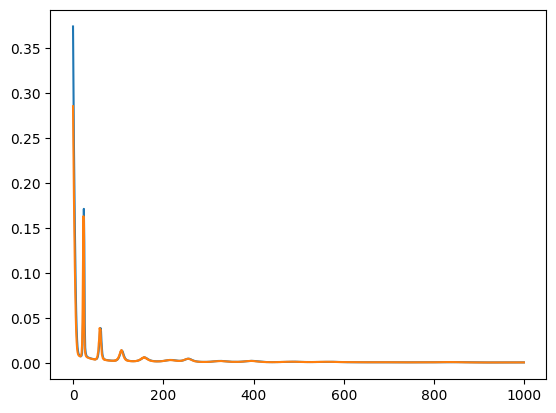

In [120]:
trainer_1.plot_train_result()

In [123]:
trainer_1.save_model()
trainer_1.predict(np.array([119, 25795]))

print(trainer_1.normalize_param)

# Next starts
load_model = LoadModel(
    'saved_model/criteria1_criteria2_parameter1_parameter2_model_weights.pth',
    'saved_model/criteria1_criteria2_parameter1_parameter2_normalize_params.pkl',
    input_colums=['criteria1', 'criteria2'],
    output_colums=['parameter1', 'parameter2']
)
print(load_model.predict(np.array([119,	25795])))

Входные данные: [  119. 25795.]
Нормализованные: [0.13793103 0.8820281 ]
Вывод модели: [-0.6891629   0.93048465]
Денормализованные данные: [23.521414 93.97608 ]
{'criteria1': {'max': 194.0, 'min': 20.0}, 'criteria2': {'max': 29245.1, 'min': -29245.1}, 'parameter1': {'max': 97.0, 'min': 10.0}, 'parameter2': {'max': 97.0, 'min': 10.0}}
Входные данные: [  119. 25795.]
Нормализованные: [0.13793103 0.8820281 ]
Вывод модели: [-0.6891629   0.93048465]
Денормализованные данные: [23.521414 93.97608 ]
[23.521414 93.97608 ]


In [ ]:
dataset.iloc[178:180]

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
178,25.0,94.0,119.0,25795.6,False,True
179,25.0,97.0,122.0,27595.7,False,True


# Проверка 2
input_colums=['parameter1', 'parameter2'],

output_colums=['criteria1', 'criteria2'],

In [ ]:
trainer_2 = Trainer(
    data=dataset,
    input_colums=['parameter1', 'parameter2'],
    output_colums=['criteria1', 'criteria2'],
    batch_size=1000,
    learning_rate=0.5,
    shuffle=False,
    test_size=0.2,
    random_state=30,
    save_path='saved_model/',
    model_middle_layers=1024,
)
trainer_2.run(1000)


Epoch [001/1000] | Train Loss: 0.179646
Validation AVG Loss:     0.035632 

Epoch [201/1000] | Train Loss: 0.000822
Validation AVG Loss:     0.000829 

Epoch [401/1000] | Train Loss: 0.000449
Validation AVG Loss:     0.000455 

Epoch [601/1000] | Train Loss: 0.000218
Validation AVG Loss:     0.000211 

Epoch [801/1000] | Train Loss: 0.000171
Validation AVG Loss:     0.000170 

Done!


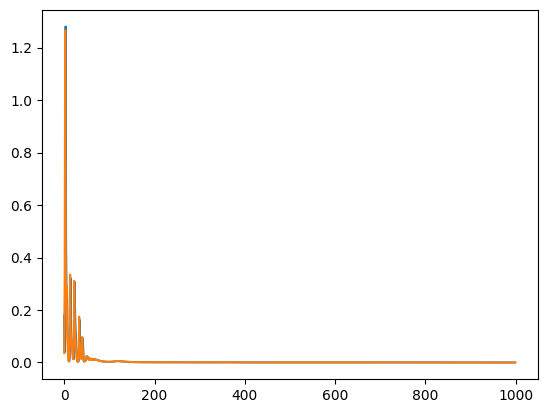

In [ ]:
trainer_2.plot_train_result()

In [ ]:
trainer_2.save_model()
trainer_2.predict(np.array([25., 94.]))

print(trainer_2.normalize_param)

Входные данные: [25. 94.]
Нормализованные: [-0.65517241  0.93103448]
Вывод модели: [0.1259896 0.877675 ]
Денормализованные данные: [  117.9611 25667.693 ]
{'parameter1': {'max': 97.0, 'min': 10.0}, 'parameter2': {'max': 97.0, 'min': 10.0}, 'criteria1': {'max': 194.0, 'min': 20.0}, 'criteria2': {'max': 29245.1, 'min': -29245.1}}


In [ ]:
dataset.iloc[178:180]

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
178,25.0,94.0,119.0,25795.6,False,True
179,25.0,97.0,122.0,27595.7,False,True


# Проверка 3
input_colums=['parameter1', 'criteria1'],

output_colums=['parameter2', 'criteria2'],

In [ ]:
trainer_3 = Trainer(
    data=dataset,
    input_colums=['parameter1', 'criteria1'],
    output_colums=['parameter2', 'criteria2'],
    batch_size=1000,
    learning_rate=0.1,
    shuffle=False,
    test_size=0.2,
    random_state=30,
    save_path='saved_model/',
    model_middle_layers=1024,
)
trainer_3.run(1000)


Epoch [001/1000] | Train Loss: 0.284985
Validation AVG Loss:     0.229308 

Epoch [201/1000] | Train Loss: 0.003807
Validation AVG Loss:     0.004516 

Epoch [401/1000] | Train Loss: 0.000897
Validation AVG Loss:     0.000935 

Epoch [601/1000] | Train Loss: 0.000544
Validation AVG Loss:     0.000554 

Epoch [801/1000] | Train Loss: 0.000358
Validation AVG Loss:     0.000359 

Done!


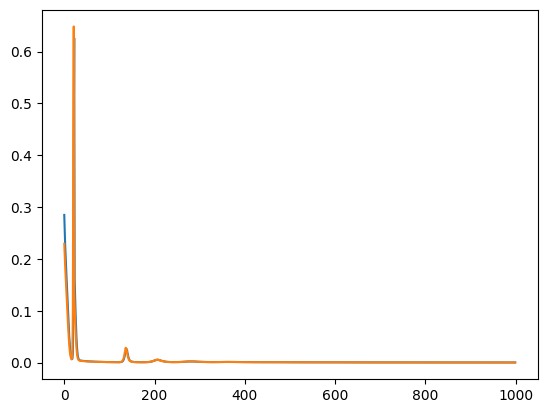

In [ ]:
trainer_3.plot_train_result()

In [ ]:
trainer_3.save_model()
trainer_3.predict(np.array([25., 119.]))

print(trainer_3.normalize_param)

Входные данные: [ 25. 119.]
Нормализованные: [-0.65517241  0.13793103]
Вывод модели: [0.94981164 0.88581824]
Денормализованные данные: [   94.8168 25905.844 ]
{'parameter1': {'max': 97.0, 'min': 10.0}, 'criteria1': {'max': 194.0, 'min': 20.0}, 'parameter2': {'max': 97.0, 'min': 10.0}, 'criteria2': {'max': 29245.1, 'min': -29245.1}}


In [ ]:
dataset.iloc[178:180]

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
178,25.0,94.0,119.0,25795.6,False,True
179,25.0,97.0,122.0,27595.7,False,True


# Проверка 4
input_colums=['parameter2', 'criteria2'],

output_colums=['parameter1', 'criteria1'],

In [ ]:
trainer_4 = Trainer(
    data=dataset,
    input_colums=['parameter2', 'criteria2'],
    output_colums=['parameter1', 'criteria1'],
    batch_size=1000,
    learning_rate=0.1,
    shuffle=False,
    test_size=0.2,
    random_state=30,
    save_path='saved_model/',
    model_middle_layers=1024,
)
trainer_4.run(1000)


Epoch [001/1000] | Train Loss: 0.271122
Validation AVG Loss:     0.238402 

Epoch [201/1000] | Train Loss: 0.004921
Validation AVG Loss:     0.004770 

Epoch [401/1000] | Train Loss: 0.002635
Validation AVG Loss:     0.002493 

Epoch [601/1000] | Train Loss: 0.001727
Validation AVG Loss:     0.001614 

Epoch [801/1000] | Train Loss: 0.001281
Validation AVG Loss:     0.001187 

Done!


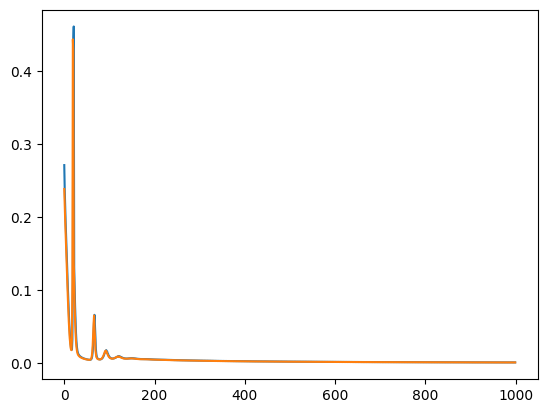

In [ ]:
trainer_4.plot_train_result()

In [ ]:
trainer_4.save_model()
trainer_4.predict(np.array([94., 25795.]))

print(trainer_4.normalize_param)

Входные данные: [   94. 25795.]
Нормализованные: [0.93103448 0.8820281 ]
Вывод модели: [-0.62589693  0.16081075]
Денормализованные данные: [ 26.273483 120.99053 ]
{'parameter2': {'max': 97.0, 'min': 10.0}, 'criteria2': {'max': 29245.1, 'min': -29245.1}, 'parameter1': {'max': 97.0, 'min': 10.0}, 'criteria1': {'max': 194.0, 'min': 20.0}}


In [ ]:
dataset.iloc[178:180]

,parameter1,parameter2,criteria1,criteria2,constraint1,constraint2
178,25.0,94.0,119.0,25795.6,False,True
179,25.0,97.0,122.0,27595.7,False,True
